# OOR state detection simulation - mixed OOR states

In this noteboook we compare the ability to detect multiple OOR states, including subtle shifts.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import oor_benchmark
import oor_benchmark.metrics.utils

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_v2/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R -i figdir
library(tidyverse)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [9]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

In [10]:

short_pop_names = {
    "DC":'conventional_dendritic_cell', 
    "naive B":'naive_B_cell',
    "memory B":'memory_B_cell',
    "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell', 
    'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
     "neutrophil":'neutrophil',
#     "cDC":'conventional_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
    'CD14+ monocyte':'CD14_positive_monocyte',
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte',
    "HPP":'hematopoietic_precursor_cell'
}

short_pop_names={v:k for k,v in short_pop_names.items()}

## Show example

In [11]:
sc.settings.figdir = figdir

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


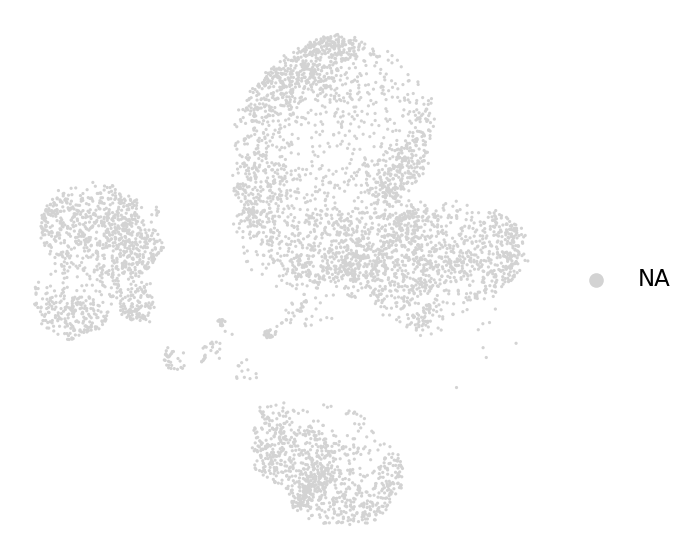

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


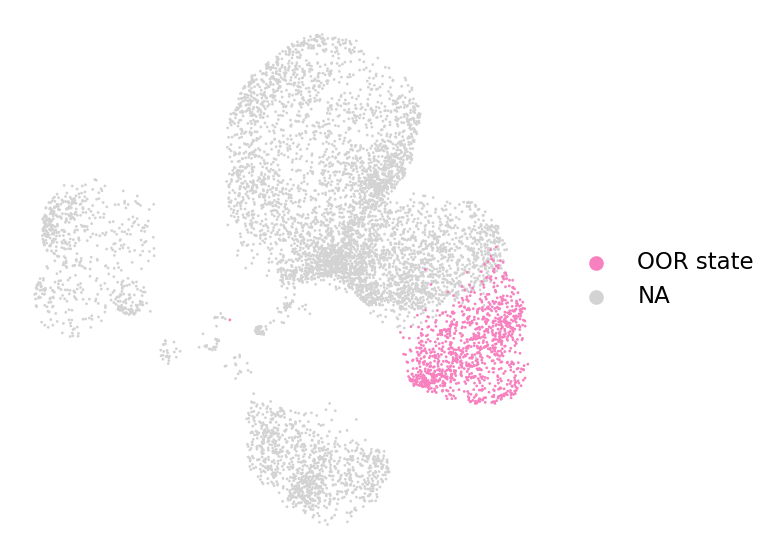

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


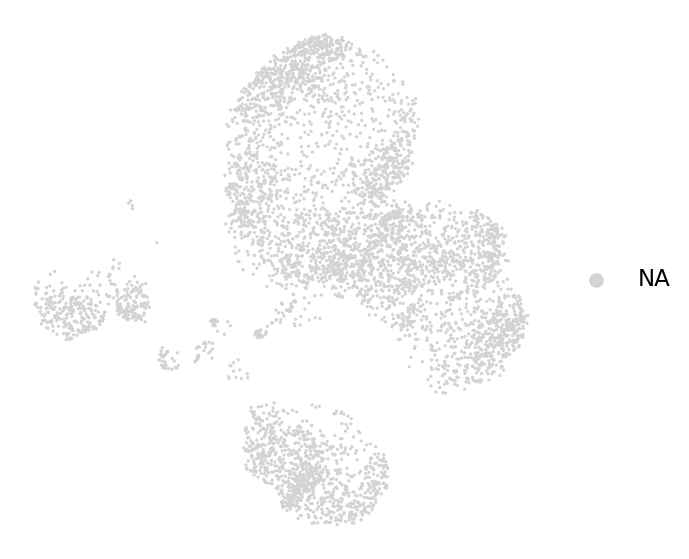

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


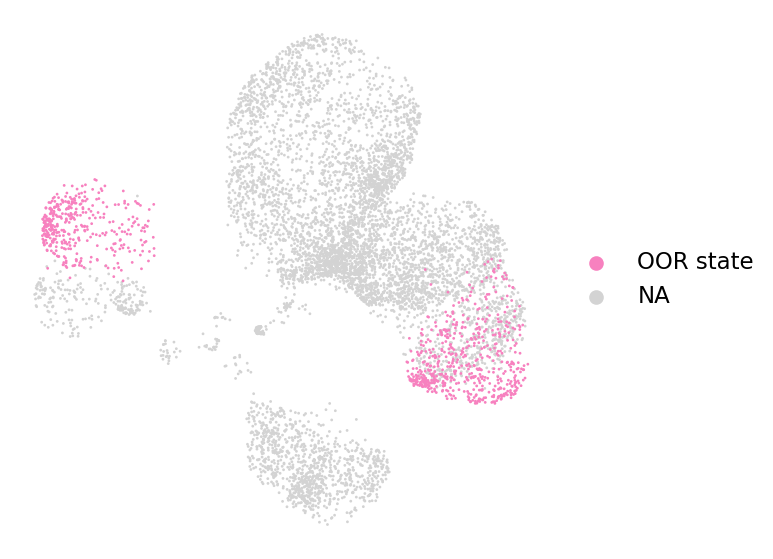

In [13]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

perturb_pop='natural_killer_cell'
remove_dir = [x for x in os.listdir(outdir) if x.startswith(f'qPBMC_500cells_demo_perturb_cell_type{perturb_pop}') and x.endswith("seed2022")][0]
mixed_dir = [x for x in os.listdir(outdir) if x.startswith(f'qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_{perturb_pop}') and x.endswith("seed2022")][0]

plt.rcParams['figure.figsize'] = [7,7]
for simdir in [remove_dir, mixed_dir]:
    adata = sc.read_h5ad(outdir + simdir + '/ACR_design.scArches_milo.h5ad', backed=False)
    adata.uns['nhood_adata'] = sc.read_h5ad(outdir + simdir + '/ACR_design.scArches_milo.nhood_adata.h5ad', backed=False)
    adata.obs['plot_oor_state'] = np.where(adata.obs['OOR_state'] == 1, 'OOR state', np.nan)
    oor_palette = {"OOR state":'#f781bf', 'nan':'lightgrey'} 
    if simdir == remove_dir:
        p='remove'
    elif simdir == 'shift_dir':
        p='shift'
    else:
        p='mixed'
    sc.pl.umap(adata[adata.obs['dataset_group'] == 'ctrl'], color=['plot_oor_state'], groups=['OOR state', 'not OOR state'], 
            palette=oor_palette, frameon=False, title='', save=f'example_perturb_{p}.ctrl.png')
    sc.pl.umap(adata[adata.obs['dataset_group'] == 'query'], color=['plot_oor_state'], 
           groups=['OOR state', 'not OOR state'], palette=oor_palette, frameon=False, title='', save=f'example_perturb_{p}.query.png')

## Read output - mixed

In [14]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

In [15]:
nhoods_res_df_all = pd.DataFrame()
tpr_res_df_all = pd.DataFrame()
for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_mixed')]:
    diff_method = 'milo'
    print(f'Reading {d}')
    nhoods_res_df = pd.read_csv(outdir + d + f'/nhoods_obs.{diff_method}.csv', index_col = 0)
    nhoods_res_df_all = pd.concat([nhoods_res_df_all, nhoods_res_df])
    tpr_res_df = pd.read_csv(outdir + d + f'/TPR_res.{diff_method}.csv', index_col = 0)
    tpr_res_df_all = pd.concat([tpr_res_df_all, tpr_res_df])

nhoods_res_df_all = nhoods_res_df_all[nhoods_res_df_all.OOR_state_name != 'neutrophil']
tpr_res_df_all = tpr_res_df_all[tpr_res_df_all.OOR_state_name != 'neutrophil']

nhoods_res_df_all['perturb_pop_pl'] = [short_pop_names[x.split("classical_monocyte_")[-1]] for x in nhoods_res_df_all['OOR_state_name']]
tpr_res_df_all['perturb_pop_pl'] = [short_pop_names[x.split('classical_monocyte_')[-1]] for x in tpr_res_df_all['OOR_state_name']]

## Keep 4 designs
nhoods_res_df_all['design'] = np.where(nhoods_res_df_all['design'] == 'CR', nhoods_res_df_all['design'] + ' ' + nhoods_res_df_all['embedding_method'], nhoods_res_df_all['design'])
tpr_res_df_all['design'] = np.where(tpr_res_df_all['design'] == 'CR', tpr_res_df_all['design'] + ' ' + tpr_res_df_all['embedding_method'], tpr_res_df_all['design'])

nhoods_res_df_all = nhoods_res_df_all[nhoods_res_df_all['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
nhoods_res_df_all = nhoods_res_df_all[~((nhoods_res_df_all['design'] == 'ACR') & (nhoods_res_df_all['embedding_method'] == 'scVI'))]
tpr_res_df_all = tpr_res_df_all[tpr_res_df_all['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
tpr_res_df_all = tpr_res_df_all[~((tpr_res_df_all['design'] == 'ACR') & (tpr_res_df_all['embedding_method'] == 'scVI'))]

Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_memory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_natural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_naive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_CD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_naive_thymus_derived_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_naive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_effector_memory_CD8_positive_alpha_beta_T_cell_

In [16]:
nhoods_res_df_all.to_csv('../../../metadata/outputs/OOR_simulations_mixed.nhood_results_all.csv')
tpr_res_df_all.to_csv('../../../metadata/outputs/OOR_simulations_mixed.TPRFPRFDR_results_all.csv')

In [15]:
%%R -i nhoods_res_df_all
head(nhoods_res_df_all)

                                             index_cell kth_distance
1 10_1038_s41591_021_01329_2-AACTCCCTCTCTGCTG-MH8919227     1.512691
2 10_1038_s41591_021_01329_2-CTGCGGACAAAGAATC-MH8919227     1.492181
3 10_1038_s41591_021_01329_2-GGGCACTAGCTAACTC-MH8919227     1.793010
4 10_1038_s41591_021_01329_2-CCGTGGATCGCGTTTC-MH8919227     1.539391
5 10_1038_s41591_021_01329_2-CACAGGCCAGATGGCA-MH8919227     1.885282
6 10_1038_s41591_021_01329_2-CCGTACTTCTTGCAAG-MH8919227     1.917447
                 nhood_annotation nhood_annotation_frac      logFC   logCPM
1             natural_killer_cell             0.9801325 -0.3119779 10.48941
2                    naive_B_cell             0.9536424  0.1957500 10.71570
3             natural_killer_cell             0.7251908 -0.5564207 10.31521
4             natural_killer_cell             0.9772728 -0.2698539 10.65101
5 CD14_low_CD16_positive_monocyte             1.0000000 -0.7798492 10.28869
6     conventional_dendritic_cell             0.9914530 -0.40

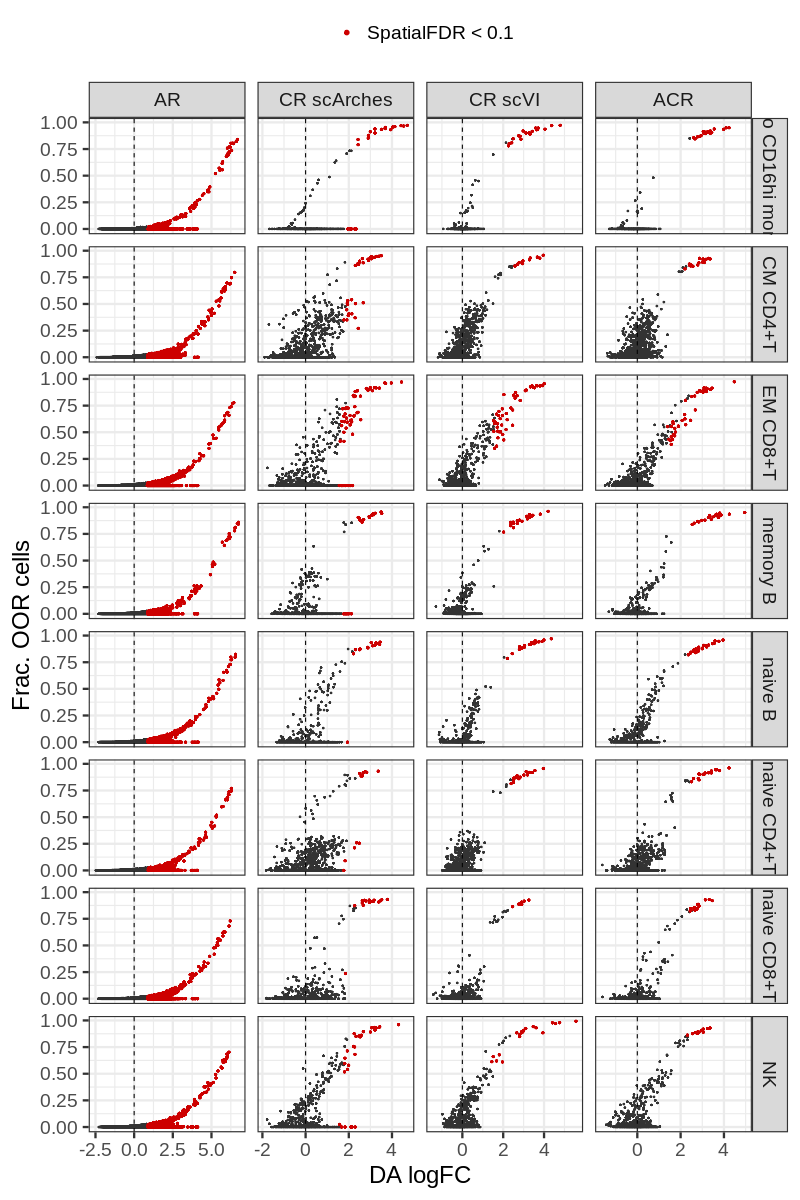

In [16]:
%%R -h 1200 -w 800
nhoods_res_df_all %>%
    mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) %>%
    ggplot(aes(OOR_score, frac_OOR_cells)) +
    rasterise(geom_point(size=0.5, color='grey20'), dpi=300) +
    rasterise(geom_point(data=. %>% filter(OOR_signif == 1), aes(color='SpatialFDR < 0.1'),
               size=0.8), dpi=300) +
    facet_grid(perturb_pop_pl~design, scales='free_x') +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    scale_color_manual(values = c(`SpatialFDR < 0.1` = 'red3')) +
    geom_vline(xintercept=0, linetype=2) +
    xlab('DA logFC') + ylab('Frac. OOR cells') +
    theme(legend.position='top') 

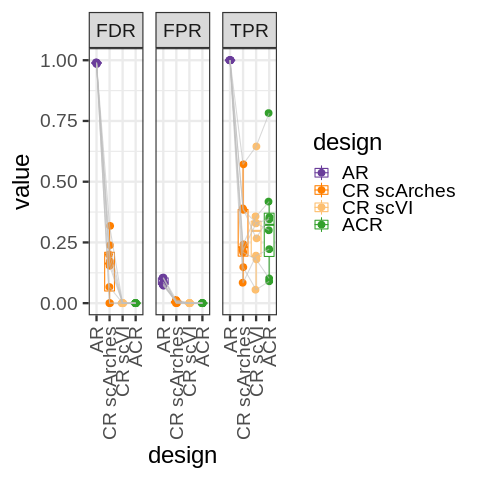

In [17]:
%%R -i tpr_res_df_all
pl2 <- tpr_res_df_all %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", "CR scVI", 'ACR'))) %>%
    pivot_longer(cols=c("TPR", 'FDR', 'FPR', 'shift_TPR'), names_to='metric') %>%
    filter(metric != 'shift_TPR') %>%
    ggplot(aes(design, value, color=design)) +
    geom_boxplot(outlier.alpha=0) +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    facet_wrap(metric~.) +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) 
    
pl2 

In [17]:
auprc_res_df_all = pd.DataFrame()
for perturb_type in ['mixed', 'perturb']:
    for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith(f'qPBMC_500cells_demo_{perturb_type}')]:
        diff_method = 'milo'
        if 'neutrophil' not in d:
            print(f'Reading {d}')
            print(f'Reading {d}')
            auprc_res_df = pd.read_csv(outdir + d + f'/AUPRC_res.{diff_method}.csv', index_col = 0)
            auprc_res_df['perturbation'] = perturb_type
            auprc_res_df_all = pd.concat([auprc_res_df_all, auprc_res_df])


Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_memory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_memory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_natural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_natural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_naive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_naive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_mixed_cell_typeclassical_monocyte_CD14_low_CD16_positive_monocyte_queryBatchdataset_id10_103

In [18]:
auprc_res_df_all.to_csv('../../../metadata/outputs/OOR_simulations_mixed.AUPRC_results_all.csv')

In [20]:
# auprc_res_df = auprc_res_df_all[['OOR_state_name', 'design', 'AUPRC', 'no_skill_thresh', 'embedding_method']].drop_duplicates()
auprc_res_df = auprc_res_df_all

## Keep 4 designs
auprc_res_df['design'] = np.where(auprc_res_df['design']=='CR', auprc_res_df['design'] + ' ' + auprc_res_df['embedding_method'], auprc_res_df['design'])
auprc_res_df = auprc_res_df[auprc_res_df['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
auprc_res_df = auprc_res_df[~((auprc_res_df['design'] == 'ACR') & (auprc_res_df['embedding_method'] == 'scVI'))]

In [21]:
auprc_res_df.OOR_state_name = np.where(auprc_res_df.OOR_state_name.str.startswith("classical_monocyte_"), auprc_res_df.OOR_state_name.str.split('classical_monocyte_', expand=True)[1], auprc_res_df.OOR_state_name)

In [22]:
cts_oi = [
    'effector_memory_CD8_positive_alpha_beta_T_cell',
 'CD14_low_CD16_positive_monocyte',
 'naive_B_cell',
 'central_memory_CD4_positive_alpha_beta_T_cell',
 'natural_killer_cell',
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell', 'memory_B_cell','naive_thymus_derived_CD8_positive_alpha_beta_T_cell'
]

In [23]:
%%R -i auprc_res_df -i cts_oi
head(auprc_res_df)

  Recall  Precision     AUPRC no_skill_thresh design embedding_method
1      1 0.06084071 0.7998465      0.06084071    ACR         scArches
2      1 0.06090808 0.7998465      0.06084071    ACR         scArches
3      1 0.06097561 0.7998465      0.06084071    ACR         scArches
4      1 0.06104329 0.7998465      0.06084071    ACR         scArches
5      1 0.06111111 0.7998465      0.06084071    ACR         scArches
6      1 0.06117909 0.7998465      0.06084071    ACR         scArches
  OOR_state_name perturbation
1  memory_B_cell        mixed
2  memory_B_cell        mixed
3  memory_B_cell        mixed
4  memory_B_cell        mixed
5  memory_B_cell        mixed
6  memory_B_cell        mixed


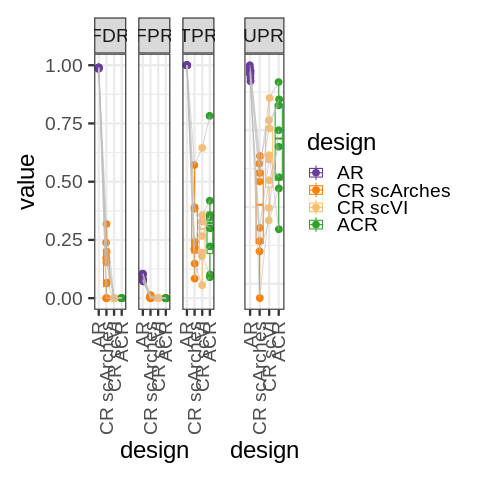

In [26]:
%%R
pl_auprc <- auprc_res_df %>%
    filter(OOR_state_name %in% cts_oi) %>%
    filter(perturbation=='mixed') %>%
    distinct(AUPRC, design, OOR_state_name, perturbation) %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", "CR scVI", 'ACR'))) %>%
    pivot_longer(cols=c("AUPRC"), names_to='metric') %>%
    ggplot(aes(design, value, color=design)) +
    geom_boxplot(outlier.alpha=0) +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    facet_wrap(metric~.) +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) +
    remove_y_axis() +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) 
    
(pl2 + pl_auprc) +
plot_layout(guides='collect', widths=c(3,1)) +
ggsave(paste0(figdir, 'all_metrics_mixed.pdf'), width=15, height=6) +
ggsave(paste0(figdir, 'all_metrics_mixed.png'), width=15, height=6)

### Compure sensitivity in shift OOR state

In [29]:
from oor_benchmark.metrics import auprc
shift_auprs_df_all = pd.DataFrame()
for ct in nhoods_res_df_all.perturb_pop_pl.unique():
    for d in nhoods_res_df_all.design.unique():
        nh_df = nhoods_res_df_all[(nhoods_res_df_all.perturb_pop_pl == ct) & (nhoods_res_df_all.design == d)].copy()
        auprc_mixed_df = auprc.auprc(nh_df, return_curve=False, bootstrap_iterations=1000, bootstrap_seed=42)
        auprc_mixed_df['design'] = d
        auprc_mixed_df['perturb_pop_pl'] = ct
        auprc_mixed_df['perturbation'] = 'mixed'
        nh_df = nh_df.loc[~((nh_df['OOR_state_group'] == 1) & (nh_df['OOR_state_group_shift'] != 1))]
        nh_df['OOR_state_group'] = nh_df['OOR_state_group_shift'].copy()
        auprc_shift_df = auprc.auprc(nh_df, return_curve=False, bootstrap_iterations=1000, bootstrap_seed=42)
        auprc_shift_df['design'] = d
        auprc_shift_df['perturb_pop_pl'] = ct
        auprc_shift_df['perturbation'] = 'mixed - small effect'
        shift_auprs_df_all = pd.concat([shift_auprs_df_all, auprc_mixed_df, auprc_shift_df])

Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 10

Read from remove perturb

In [30]:
nhoods_res_df_all = pd.DataFrame()
tpr_res_df_all = pd.DataFrame()
for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_perturb')]:
    diff_method = 'milo'
    print(f'Reading {d}')
    nhoods_res_df = pd.read_csv(outdir + d + f'/nhoods_obs.{diff_method}.csv', index_col = 0)
    nhoods_res_df_all = pd.concat([nhoods_res_df_all, nhoods_res_df])

nhoods_res_df_all = nhoods_res_df_all[nhoods_res_df_all.OOR_state_name != 'neutrophil']
nhoods_res_df_all['perturb_pop_pl'] = [short_pop_names[x.split("classical_monocyte_")[-1]] for x in nhoods_res_df_all['OOR_state_name']]

## Keep 4 designs
nhoods_res_df_all['design'] = np.where(nhoods_res_df_all['design'] == 'CR', nhoods_res_df_all['design'] + ' ' + nhoods_res_df_all['embedding_method'], nhoods_res_df_all['design'])
nhoods_res_df_all = nhoods_res_df_all[nhoods_res_df_all['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
nhoods_res_df_all = nhoods_res_df_all[~((nhoods_res_df_all['design'] == 'ACR') & (nhoods_res_df_all['embedding_method'] == 'scVI'))]

Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed202

In [32]:
remove_auprs_df_all = pd.DataFrame()
for ct in nhoods_res_df_all.perturb_pop_pl.unique():
    for d in nhoods_res_df_all.design.unique():
        nh_df = nhoods_res_df_all[(nhoods_res_df_all.perturb_pop_pl == ct) & (nhoods_res_df_all.design == d)].copy()
        auprc_mixed_df = auprc.auprc(nh_df, return_curve=False, bootstrap_iterations=1000, bootstrap_seed=42)
        auprc_mixed_df['design'] = d
        auprc_mixed_df['perturb_pop_pl'] = ct
        auprc_mixed_df['perturbation'] = 'remove'
        remove_auprs_df_all = pd.concat([remove_auprs_df_all, auprc_mixed_df])

Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 10

In [44]:
# all_auprc_df = auprc_res_df_all[auprc_res_df_all.perturbation != 'shift']
# all_auprc_df['perturb_pop_pl'] = [short_pop_names[x.split('classical_monocyte_')[-1]] for x in all_auprc_df.OOR_state_name]
# all_auprc_df = all_auprc_df[all_auprc_df['perturb_pop_pl'].isin([short_pop_names[x] for x in cts_oi])]

# shift_auprs_df_all['perturbation'] = 'mixed - small effect'

# auprc_compare = pd.merge(shift_auprs_df_all[['AUPRC', 'design', 'perturb_pop_pl']].drop_duplicates(), all_auprc_df[['AUPRC', 'design', 'perturb_pop_pl']].drop_duplicates(), 
#          on=['perturb_pop_pl', 'design'], suffixes=['_shift', '_both'])
auprc_compare = pd.concat([remove_auprs_df_all, shift_auprs_df_all])
auprc_compare = auprc_compare[auprc_compare['perturb_pop_pl'].isin([short_pop_names[x] for x in cts_oi])]
auprc_compare

,AUPRC,no_skill_thresh,CI_lower,CI_upper,design,perturb_pop_pl,perturbation
0,0.568656,0.006000,0.176769,0.929630,ACR,CD14lo CD16hi monocyte,remove
0,0.025418,0.019822,0.017521,0.042024,CR scArches,CD14lo CD16hi monocyte,remove
0,0.254224,0.004053,0.002716,0.751755,CR scVI,CD14lo CD16hi monocyte,remove
0,0.484026,0.000369,0.282658,0.684184,AR,CD14lo CD16hi monocyte,remove
0,0.393030,0.115987,0.320580,0.484129,ACR,naive CD8+T,remove
...,...,...,...,...,...,...,...
0,0.677204,0.263041,0.627327,0.725859,CR scArches,CM CD4+T,mixed - small effect
0,0.734871,0.220133,0.684275,0.784622,CR scVI,CM CD4+T,mixed
0,0.692593,0.285877,0.636549,0.738488,CR scVI,CM CD4+T,mixed - small effect
0,0.961771,0.001227,0.922605,0.988268,AR,CM CD4+T,mixed


In [41]:
stats_df = auprc_compare[['AUPRC', 'perturb_pop_pl', 'perturbation', 'design']].drop_duplicates()

stats.ttest_rel(
    stats_df[(stats_df['design'] == 'CR scVI') & (stats_df['perturbation'] == 'mixed - small effect')]['AUPRC'],
    stats_df[(stats_df['design'] == 'ACR') & (stats_df['perturbation'] == 'mixed - small effect')]['AUPRC'],
    alternative='less'
)


Ttest_relResult(statistic=-0.6061790643467788, pvalue=0.2817641759492766)

In [45]:
%%R -i auprc_compare
head(auprc_compare)

       AUPRC no_skill_thresh    CI_lower   CI_upper      design
1 0.56865650    0.0060000000 0.176768559 0.92962963         ACR
2 0.02541819    0.0198216056 0.017520954 0.04202355 CR scArches
3 0.25422404    0.0040526849 0.002715752 0.75175519     CR scVI
4 0.48402568    0.0003692838 0.282658162 0.68418386          AR
5 0.39302960    0.1159874608 0.320579726 0.48412859         ACR
6 0.60310349    0.1754932503 0.535587042 0.66857185 CR scArches
          perturb_pop_pl perturbation
1 CD14lo CD16hi monocyte       remove
2 CD14lo CD16hi monocyte       remove
3 CD14lo CD16hi monocyte       remove
4 CD14lo CD16hi monocyte       remove
5            naive CD8+T       remove
6            naive CD8+T       remove


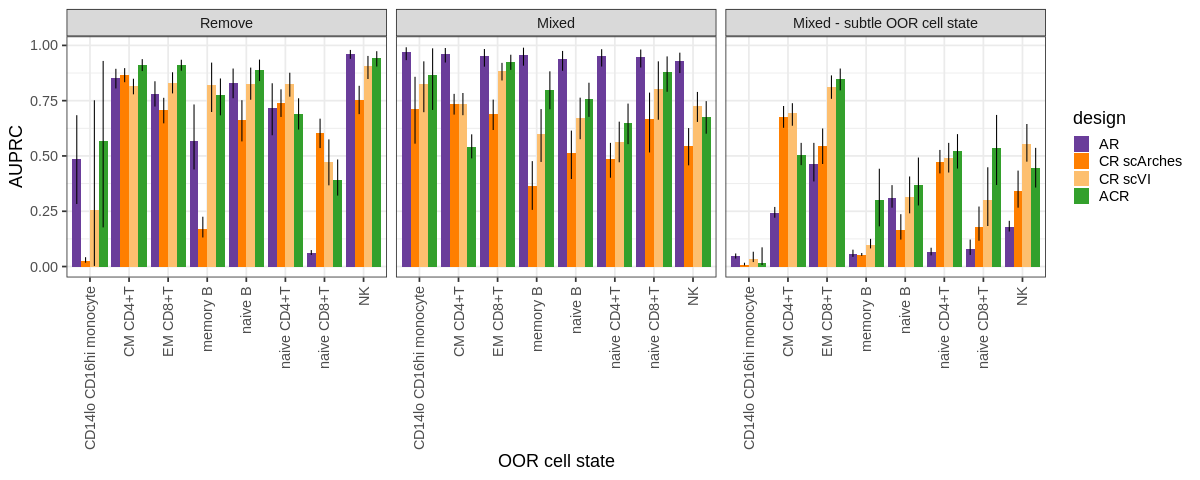

In [50]:
%%R -i cts_oi -w 1200
perturb_labeller <- c(
    'remove'='Remove',
    'mixed'='Mixed',
    `mixed - small effect`='Mixed - subtle OOR cell state'
)

auprc_compare %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", "CR scVI", 'ACR'))) %>%
#     filter(design!='AR') %>%
    distinct(AUPRC, design, no_skill_thresh, perturb_pop_pl, perturbation, CI_lower, CI_upper) %>%
    mutate(perturbation = factor(perturbation, levels=c('remove', "mixed", "mixed - small effect"))) %>%
    ggplot(aes(perturb_pop_pl, AUPRC, fill=design)) +
    geom_col(position='dodge') +
    geom_errorbar(position=position_dodge(width=0.9), aes(ymin=CI_lower,ymax=CI_upper), width=0) +
    scale_fill_manual(values=design_palette) +
    theme_bw(base_size=18) +
    facet_grid(.~perturbation, labeller=labeller(perturbation=perturb_labeller)) +
    xlab("OOR cell state") +
    theme(axis.text.x = element_text(angle=90, hjust=1, vjust=0.5)) +
    ggsave(paste0(figdir, 'AUPRC_barplot_perturb_comparison.pdf'), width=15, height=6) +
    ggsave(paste0(figdir, 'AUPRC_barplot_perturb_comparison.png'), width=15, height=6)